# Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Содержание

[Общая информация](#Общая_информация)

[Предобработка данных](#Предобработка_данных)

[Исследовательский анализ данных](#Исследовательский_анализ_данных)

[Обучение моделей](#Обучение_моделей)

[Анализ моделей](#Анализ_моделей)

[Итоговый вывод](#Итоговый_вывод)

**Исходные данные.**

Для этой задачи заказчик предоставил данные с признаками:

- **DateCrawled** — дата скачивания анкеты из базы
- **VehicleType** — тип автомобильного кузова
- **RegistrationYear** — год регистрации автомобиля
- **Gearbox** — тип коробки передач
- **Power** — мощность (л. с.)
- **Model** — модель автомобиля
- **Kilometer** — пробег (км)
- **RegistrationMonth** — месяц регистрации автомобиля
- **FuelType** — тип топлива
- **Brand** — марка автомобиля
- **Repaired** — была машина в ремонте или нет
- **DateCreated** — дата создания анкеты
- **NumberOfPictures** — количество фотографий автомобиля
- **PostalCode** — почтовый индекс владельца анкеты (пользователя)
- **LastSeen** — дата последней активности пользователя
- **Price** — цена в евро (целевой признак)

# Загрузка библиотек

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import re
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import time
import itertools
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# Настройка отображения графиков
%matplotlib inline
sns.set(
    font_scale=1.3,
    style="whitegrid",
    rc={'figure.figsize':(20,7)})

# Установка опции отображения широких датафреймов
pd.set_option('display.max_colwidth', None)

RANDOM_STATE=17

## Подготовка данных

<a id='Общая_информация'></a>

### Общая информация

In [2]:
df = pd.read_csv('/datasets/autos.csv')
display(df.head())
display(df.info())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

**Вывод**

Датафрейм содержит 354369 объектов и 16 признаков, присутствуют и пропуски, и явные ошибки среди значений некоторых признаков.


Необходима предобработка данных:

- очистить датафрейм от избыточной информации (убрать лишние признаки, осложняющие процесс построения моделей машинного обучения).
- произвести обработку или удаление пропущенных значений.
- проверить наличие дубликатов в данных.

<a id='Предобработка_данных'></a>

### Предобработка данных

#### Удаление ненужных признаков

In [3]:
# рассмотрим признак NumberOfPictures

display(df.NumberOfPictures.unique())

array([0])

В столбце **NumberOfPictures** все значения равны нулю. Значит наличие этого столбца не имеет никакого смысла. Удалим его.

In [4]:
df = df.drop(columns=['NumberOfPictures'])

Далее, рассмотрим столбцы с указанием времени:

- **DateCrawled** — дата скачивания анкеты из базы
- **DateCreated** — дата создания анкеты
- **LastSeen** — дата последней активности пользователя

Эти столбцы никак не влияют на ценообразование автомобиля и, в контексте данной задачи, не имеют смысла. Их тоже удалим.

In [5]:
df = df.drop(columns=['DateCrawled', 'DateCreated', 'LastSeen'])

Рассмотрим столбец **RegistrationMonth**. Если по столбцу **RegistrationYear** можно определить возраст автомобиля, то столбец **RegistrationMonth** не несет в себе полезной информации. Его тоже удалим.

In [6]:
df = df.drop(columns=['RegistrationMonth'])

In [7]:
# проверим данные после удаления ненужных признаков

list(df.columns)

['Price',
 'VehicleType',
 'RegistrationYear',
 'Gearbox',
 'Power',
 'Model',
 'Kilometer',
 'FuelType',
 'Brand',
 'Repaired',
 'PostalCode']

Проверим количественное и процентное содержание пропусков оставшихся признаков.

In [8]:
def nan_percent(data):
    new_data = data.isna().sum().to_frame()
    new_data = new_data.rename(columns = {0: 'missing_values'})
    new_data['% of total'] = ((new_data['missing_values'] / data.shape[0])*100).round(2)
    return new_data.sort_values(by = 'missing_values', ascending = False)

nan_percent(df)

,missing_values,% of total
Repaired,71154,20.08
VehicleType,37490,10.58
FuelType,32895,9.28
Gearbox,19833,5.60
Model,19705,5.56
Price,0,0.00
RegistrationYear,0,0.00
Power,0,0.00
Kilometer,0,0.00
Brand,0,0.00


Признак **Repaired**

Больше всего пропусков содержится в признаке Repaired, который отражает факт проведения ремонта у автомобиля. Это важный показатель, который может сильно влиять на цену автомобиля. От чего может зависеть вероятность ремонта? Возраст автомобиля? Но машину могут купить когда-то и просто хранить в гараже. Думаю, что лучше остальных уровень эксплуатации отражает пробег автомобиля. Поэтому посмотрим на зависимость вероятности ремнта от количества пройденного километража. 

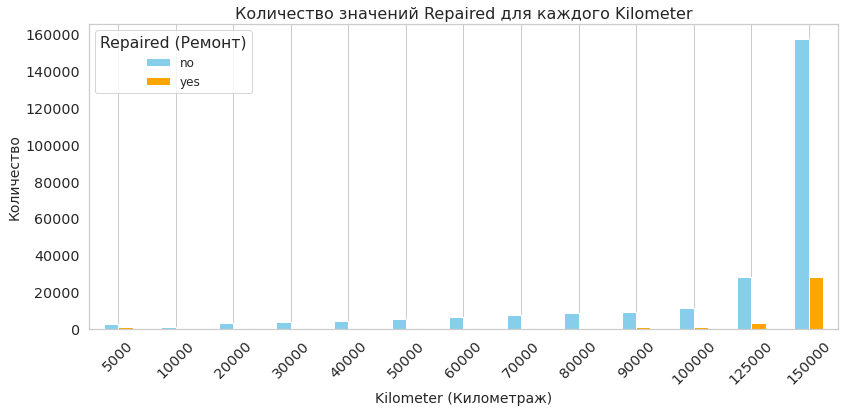

In [9]:
# Группировка данных
data_grouped = df[df['Repaired'].notna()].groupby(['Kilometer', 'Repaired']).size().unstack(fill_value=0)

# Построение графика
data_grouped.plot(kind='bar', figsize=(12, 6), stacked=False, color=['skyblue', 'orange'])

# Настройка графика
plt.title('Количество значений Repaired для каждого Kilometer', fontsize=16)
plt.xlabel('Kilometer (Километраж)', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Repaired (Ремонт)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Согласно этому графику можно сделать вывод, что почти все б/у машины смогли избежать ремонта. Это выглядит неправдоподобно. Чтобы не терять информацию в остальном массиве, заполним пустоты меткой N/A (недоступно).

In [10]:
df['Repaired']=df['Repaired'].fillna('N/A')

Признак **VehicleType**

Тип кузова - тоже важный признак, влияющий на ценообразование. От чего может зависеть тип кузова? Думаю, что от бренда и марки автомобиля. Например, смотрим какой самый популярный кузов у бренда jeep модели grand и указываем его в пропуске у аналогичного автомобиля.	

In [11]:
# Исключаем строки с пропусками в столбце Model
filtered_df = df[df['Model'].notna()]

# Заполнение пропусков в VehicleType на основе моды для Brand и Model из отфильтрованного DataFrame
df['VehicleType'] = df['VehicleType'].fillna(
    filtered_df.groupby(['Brand', 'Model'])['VehicleType'].transform(lambda x: x.mode().iloc[0] \
                                                                     if not x.mode().empty else None))

In [12]:
# там, где не удалось определить тип кузова, заполняем меткой N/A

df['VehicleType']=df['VehicleType'].fillna('N/A')

Признаки **FuelType**, **Gearbox**, **Model**

Заполняем меткой N/A

In [13]:
df['FuelType']=df['FuelType'].fillna('N/A')
df['Gearbox']=df['Gearbox'].fillna('N/A')
df['Model']=df['Model'].fillna('N/A')

#### Удаление явных дубликатов

In [14]:
print('Количество явных дубликатов:', df.duplicated().sum())

Количество явных дубликатов: 23553


In [15]:
df = df.drop_duplicates()
print('Количество явных дубликатов:', df.duplicated().sum())

Количество явных дубликатов: 0


In [16]:
# проверим на наличие пропусков

display(df.isna().sum())

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
PostalCode          0
dtype: int64

Признак **PostalCode**

И последним удаляем столбец PostalCode. Я удалила его после избавления от явных дубликатов, потому что этот столбец служил своего рода идентификатором. Если бы я убрала его до удаления явных дубликатов, то много строк, которые на самом деле не являются дубликатами, могли бы ими показаться.

In [17]:
df = df.drop(columns=['PostalCode'])

<a id='Исследовательский_анализ_данных'></a>

### Исследовательский анализ данных

,Price
count,330816.000000
mean,4381.553220
std,4506.239559
min,0.000000
25%,1000.000000
50%,2699.000000
75%,6300.000000
max,20000.000000


Коэффициент вариации равен 1.0284571092560046


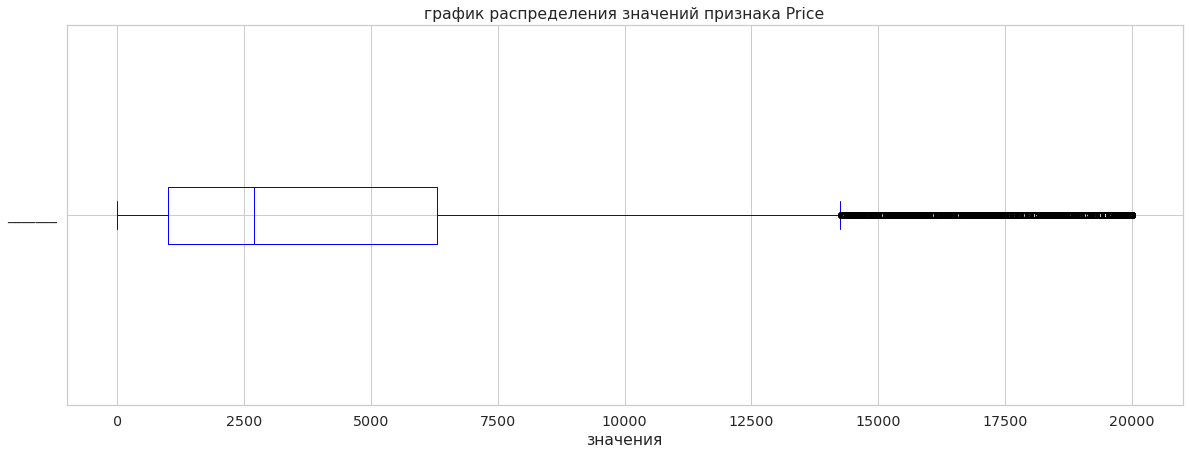

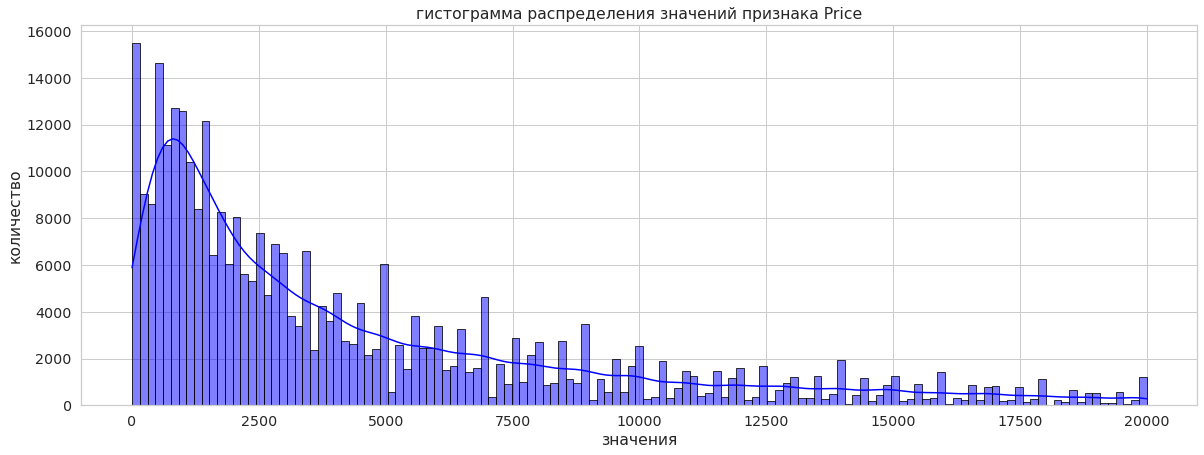

,RegistrationYear
count,330816.000000
mean,2004.179595
std,89.516757
min,1000.000000
25%,1999.000000
50%,2003.000000
75%,2008.000000
max,9999.000000


Коэффициент вариации равен 0.044665037689125865


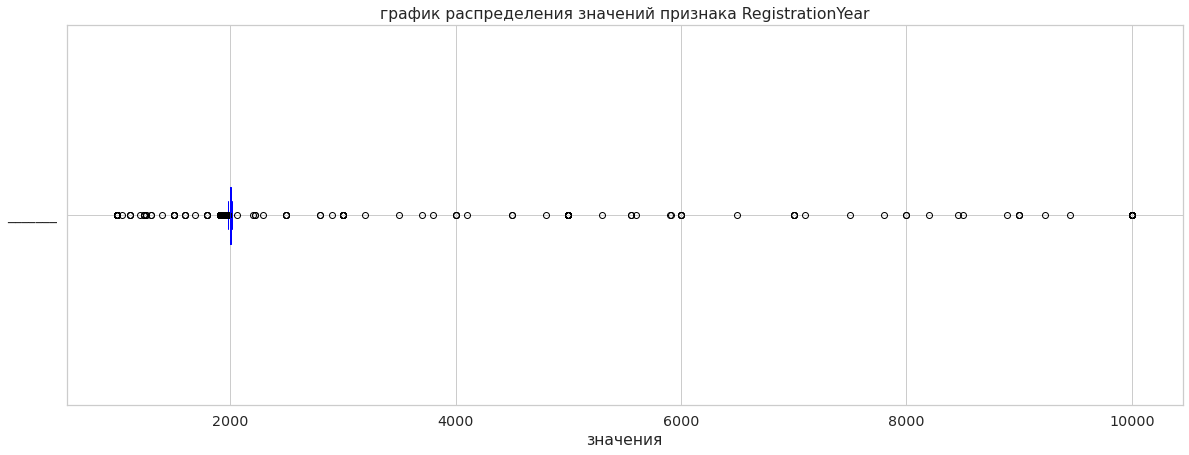

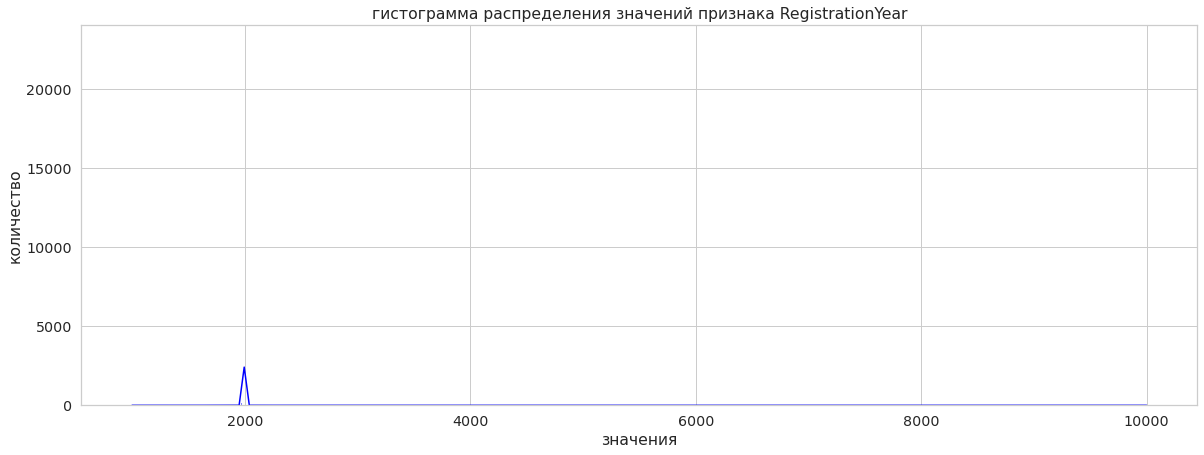

,Power
count,330816.000000
mean,109.799076
std,194.866714
min,0.000000
25%,68.000000
50%,103.000000
75%,140.000000
max,20000.000000


Коэффициент вариации равен 1.774757330180175


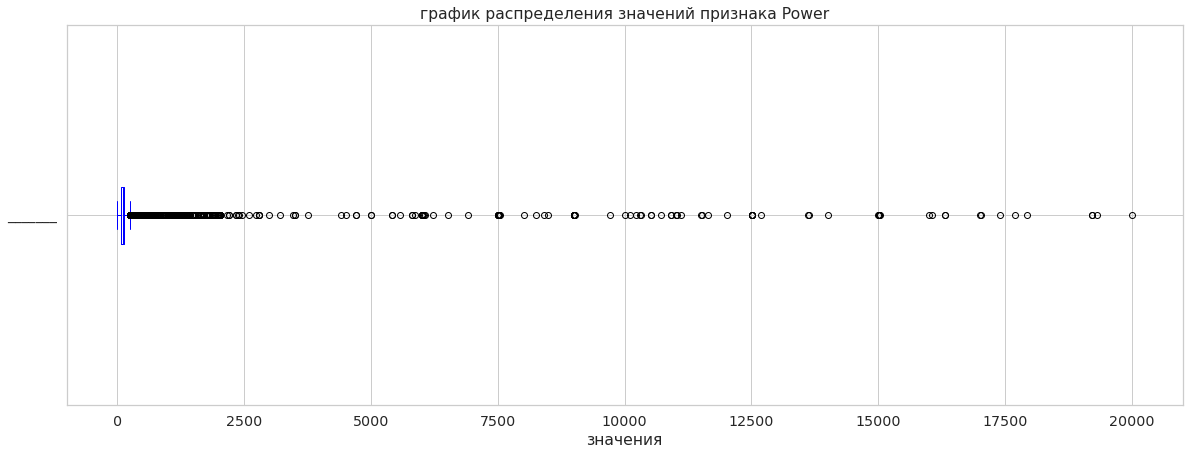

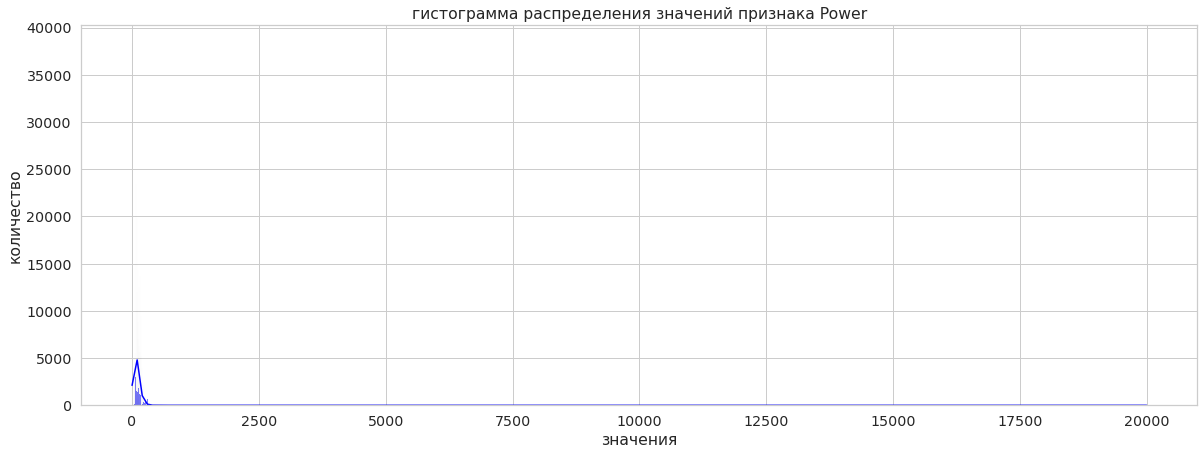

In [18]:
col_num = ['Price', 'RegistrationYear', 'Power']

for i in col_num:
    df.boxplot([i], vert=False, color='blue')
    display(pd.DataFrame(df[i].describe()))
    print(f'Коэффициент вариации равен {statistics.stdev(df[i]) / df[i].mean()}')

    plt.title('график распределения значений признака '+i)
    plt.xlabel('значения')
    plt.yticks([1], ['_______'])
    plt.show();

    sns.histplot(df[i], kde=True, color='blue', edgecolor='black')
    plt.title('гистограмма распределения значений признака '+i)
    plt.xlabel("значения")
    plt.ylabel("количество")
    plt.show();

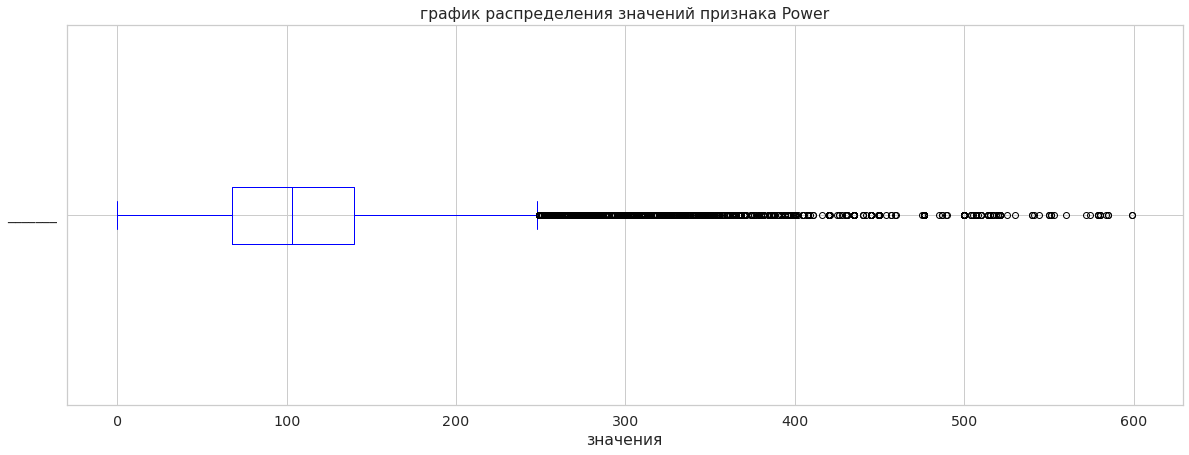

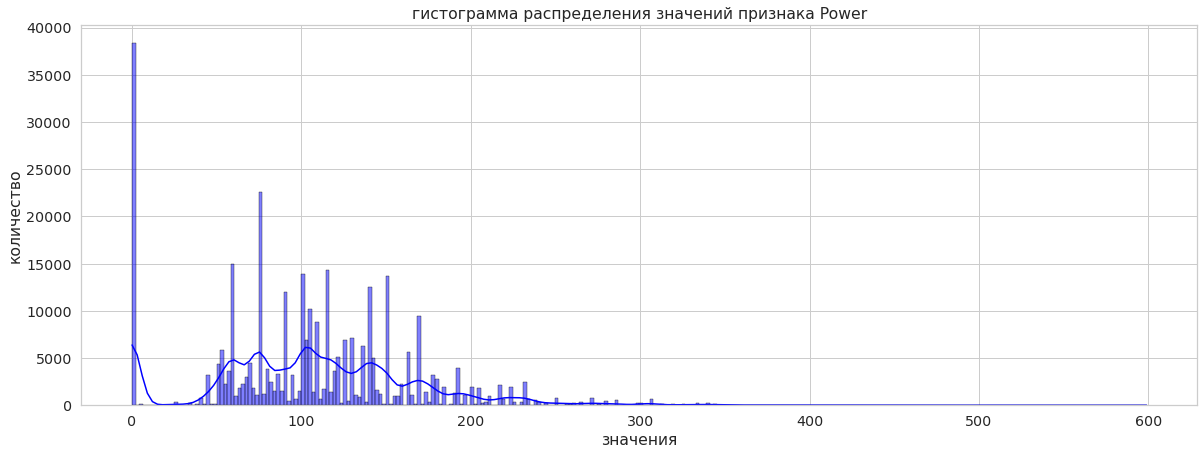

In [19]:
# взглянем на признак Power c фокусом на начало графика
df_power = df.query('Power < 600')

df_power.boxplot(['Power'], vert=False, color='blue')
plt.title('график распределения значений признака Power')
plt.xlabel('значения')
plt.yticks([1], ['_______'])
plt.show();

sns.histplot(df_power['Power'], kde=True, color='blue', edgecolor='black')
plt.title('гистограмма распределения значений признака Power')
plt.xlabel("значения")
plt.ylabel("количество")
plt.show();

<p style="text-align: center;">Price (цена):</p>

||||
|-----------|-----------|-----------|
|**Среднее значение**|5 100||
|**Медиана**|3 500||
|**Коэффициент вариации**|1.03||
|**Статистические выбросы слева**|отсутствуют||
|**Статистические выбросы справа**|свыше 14 500||

**Интерпретация:** Коэффициент вариации (отношение стандартного отклонения к арифметическому среднему значению) равен 1.03. Согласно правилам статистики, если коэффициент равен 1, то разброс считается высоким. Также, в пользу высокого разброса говорит и существенная разница между арифметическим средним и медианой. Медиана данных смещена влево, что говорит о том, что низких цен в компании значительно больше, чем высоких, что выглядит весьма логичным.
Аномальной выглядит самая низкая цена в 0 евро. Насколько бы в аварийном состоянии ни была бы машина, она должна что-то да стоить. Будем считать, что стоимость машине ниже 50 евро уже не релевантна для нашей задачи. Поэтому отсечем объявления с такими подозрительными ценами.
<hr>
<p style="text-align: center;">RegistrationYear (год регистрации):</p>

||||
|-----------|-----------|-----------|
|**Среднее значение**|2002,8||
|**Медиана**|2003||
|**Коэффициент вариации**|0.00||
|**Статистические выбросы слева**|ниже 1986||
|**Статистические выбросы справа**|отсутствуют||

**Интерпретация:** Коэффициент вариации почти равен нулю, что говорит об очень низкой дисерсии. Также, в пользу низкой дисперсии говорит и равенство между средним и медианой. Согласно гистограмме, почти все продаваемые автомобили были произведены после 2000 года.
Аномальной выглядят даты уходящие к началу 20-го века, что вряд ли соответствует действительности. Или же это штучные раритетные автомобили, которые являются статистическими выбросами. В целом, автомобилей до 1970 года практически нет и их можно отсечь.
<hr>
<p style="text-align: center;">Power (мощность):</p>

||||
|-----------|-----------|-----------|
|**Среднее значение**|119,7||
|**Медиана**|110||
|**Коэффициент вариации**|1.20||
|**Статистические выбросы слева**|отсутствуют||
|**Статистические выбросы справа**|отсутствуют||

**Интерпретация:** Значений мощности больше 600 почти отсутствуют, это будет верхним пределом фильтрации. А нижни пределом возьмем мощность в 30 лощадиных сил. Мощность ниже этого значения уже редки.

,Kilometer
count,330816.000000
mean,128253.591120
std,37943.120916
min,5000.000000
25%,125000.000000
50%,150000.000000
75%,150000.000000
max,150000.000000


Коэффициент вариации равен 0.29584451073958307


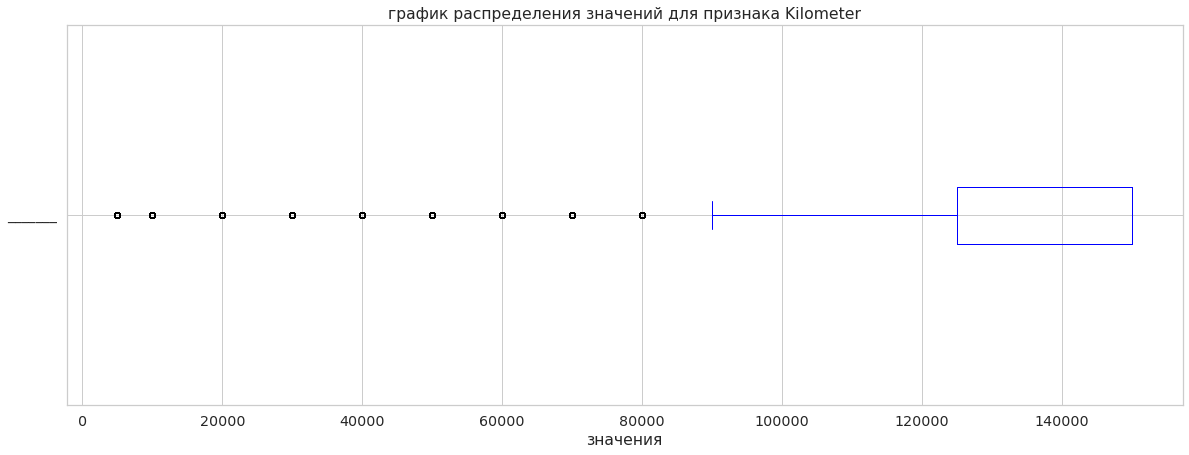

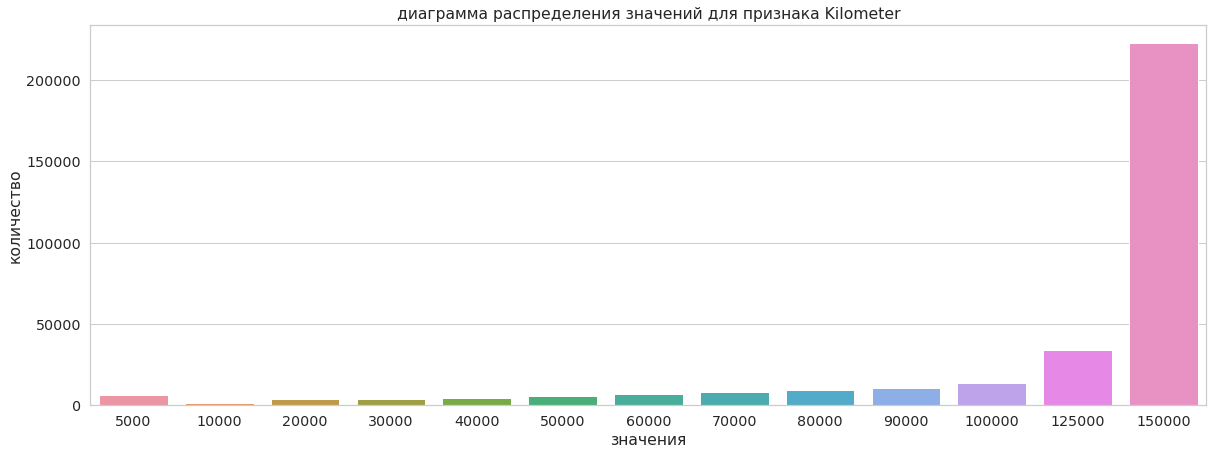

In [20]:
df.boxplot(['Kilometer'], vert=False, color='blue')
display(pd.DataFrame(df['Kilometer'].describe()))
print(f'Коэффициент вариации равен {statistics.stdev(df.Kilometer) / df.Kilometer.mean()}')
plt.title('график распределения значений для признака Kilometer')
plt.xlabel('значения')
plt.yticks([1], ['_______'])
plt.show();
    
sns.countplot(x = 'Kilometer', data = df)
plt.title('диаграмма распределения значений для признака Kilometer')
plt.xlabel("значения")
plt.ylabel("количество")
plt.show();

Чем выше пробег, тем выше вероятность продажи автомобиля. Крайние значения графика адекватные. Здесь все в порядке.

In [21]:
# делаем срезы согласно выводам выше

df = df[df['Price']>50]
df = df[(df['RegistrationYear']>1970)&(df['RegistrationYear']<=2016)]
df = df[(df['Power']>30)&(df['Power']<600)]

In [22]:
# проверяем сколько строк осталось

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273709 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             273709 non-null  int64 
 1   VehicleType       273709 non-null  object
 2   RegistrationYear  273709 non-null  int64 
 3   Gearbox           273709 non-null  object
 4   Power             273709 non-null  int64 
 5   Model             273709 non-null  object
 6   Kilometer         273709 non-null  int64 
 7   FuelType          273709 non-null  object
 8   Brand             273709 non-null  object
 9   Repaired          273709 non-null  object
dtypes: int64(4), object(6)
memory usage: 23.0+ MB


После удаления явных дубликатов, в датафрейме осталось 331 тысяч строк. Сейчас 273 тысяч строк. Мы избавились от 17,5 % данных.

## Обучение моделей

В рамках исследования мы будет обучать 3 модели регрессии:

- CatBoost
- RandomForest
- LightGBM

In [23]:
# разделим признаки на входные и целевой

features = df.drop(['Price'], axis=1)  
target = df['Price']

In [24]:
# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=RANDOM_STATE)

In [25]:
# для построения некоторых моделей нам потребуются категориальные признаки отдельно

cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [26]:
# Преобразование типов данных
for dataset in [X_train, X_test]:
    dataset[cat_features] = dataset[cat_features].astype('category')

In [27]:
# Обучение моделей
best_rmse = float('inf')
best_model_name = None
best_model = None

<div style="text-align: center;">
CatBoost
</div>

In [28]:
cat_params = {
    'n_estimators': [100, 200],
    'depth': [6]
}

cat_model = CatBoostRegressor(
    loss_function='MAE',
    eval_metric='RMSE',
    cat_features=cat_features,
    verbose=0,
    random_state=RANDOM_STATE
)

cat_grid = RandomizedSearchCV(cat_model, 
                              cat_params,
                              n_iter=10,
                              cv=3, 
                              scoring='neg_root_mean_squared_error', 
                              n_jobs=-1)

cat_grid.fit(X_train, y_train)

cat_rmse = -cat_grid.best_score_
print(f"CatBoost RMSE (на кросс-валидации): {cat_rmse:.4f}")
print(f"Лучшие параметры CatBoost: {cat_grid.best_params_}")

if cat_rmse < best_rmse:
    best_rmse = cat_rmse
    best_model_name = "CatBoost"
    best_model = cat_grid.best_estimator_

CatBoost RMSE (на кросс-валидации): 1846.2185
Лучшие параметры CatBoost: {'n_estimators': 200, 'depth': 6}


<div style="text-align: center;">
Random Forest
</div>

Так как модель **Random Forest** в библиотеке sklearn не умеет напрямую работать с категориальными данными, она ожидает, что все признаки будут числовыми. Поэтому перед использованием категориальных данных их нужно закодировать в числовую форму.

In [29]:
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns

# Кодирование категориальных признаков
encoder = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_columns)
    ],
    remainder='passthrough'
)
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [6],
    'min_samples_leaf': [3, 5]
}

rf_model = RandomForestRegressor(random_state=RANDOM_STATE)

rf_grid = RandomizedSearchCV(rf_model, 
                             rf_params,
                             n_iter=10,
                             cv=3, 
                             scoring='neg_root_mean_squared_error', 
                             n_jobs=-1)

rf_grid.fit(X_train_encoded, y_train)

rf_rmse = -rf_grid.best_score_
print(f"Random Forest RMSE (на кросс-валидации): {rf_rmse:.4f}")
print(f"Лучшие параметры Random Forest: {rf_grid.best_params_}")

if rf_rmse < best_rmse:
    best_rmse = rf_rmse
    best_model_name = "Random Forest"
    best_model = rf_grid.best_estimator_

Random Forest RMSE (на кросс-валидации): 2197.8668
Лучшие параметры Random Forest: {'n_estimators': 200, 'min_samples_leaf': 5, 'max_depth': 6}


<div style="text-align: center;">
LightGBM
</div>

In [ ]:
light_params = {
    'n_estimators': [100, 200],
    'max_depth': [6]
}

light_model = LGBMRegressor(random_state=RANDOM_STATE)

light_grid = RandomizedSearchCV(
    light_model,
    light_params,
    n_iter=10,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

light_grid.fit(X_train, y_train, categorical_feature=cat_features)

light_rmse = -light_grid.best_score_
print(f"LightGBM RMSE (на кросс-валидации): {light_rmse:.4f}")
print(f"Лучшие параметры LightGBM: {light_grid.best_params_}")

if light_rmse < best_rmse:
    best_rmse = light_rmse
    best_model_name = "LightGBM"
    best_model = light_grid.best_estimator_

In [ ]:
# Итог
print(f"Лучшая модель: {best_model_name} с RMSE (на кросс-валидации): {best_rmse}")

На первый взгляд все очевидно: **LightGBM** - самая лучшая и быстрая модель, **RandomForest** - самая худшая. Однако необходимо рассмотреть обучение и предсказание отдельных моделей - самых лучших для каждого вида. Мы определили, что модели **LightGBM** и **CatBoost** показывают лучшие результаты с увеличением параметров n_estimators и max_depth. В связи с этим, а также в целях улучшения метрики RMSE, при анализе моделей предлагается зафиксировать следующие значения гиперпарметров:

для **LightGBM** и **CatBoost**:
- n_estimators = 200
- max_depth = 6

для **RandomForest**:
- n_estimators = 100
- max_depth = 6
- min_samples_leaf = 3

## Анализ моделей

Анализ моделей произведем при помощи валидационной выборки.

In [ ]:
# Функция для вывода информации о модели
def print_model_info(model_name, grid, X_train, y_train):
    # Время обучения модели
    start_fit = time.time()
    grid.best_estimator_.fit(X_train, y_train)
    fit_time = time.time() - start_fit

    # RMSE из кросс-валидации
    rmse = -grid.best_score_

    # Время предсказания
    start_predict = time.time()
    _ = grid.best_estimator_.predict(X_train)  # Предсказания на тренировочной выборке
    predict_time = time.time() - start_predict

    print(f'Модель: {model_name}')
    print(f'Средний RMSE (на кросс-валидации): {rmse:.4f}')
    print(f'Время обучения: {fit_time:.2f} секунд')
    print(f'Время предсказания: {predict_time:.2f} секунд')
    print('-' * 50)

    return rmse, fit_time, predict_time

# Анализ моделей
results = pd.DataFrame(columns=['Model', 'Fit Time (s)', 'Predict Time (s)', 'Mean RMSE'])

In [ ]:
# CatBoost
cat_rmse, cat_fit_time, cat_predict_time = print_model_info("CatBoost", cat_grid, X_train, y_train)
results = results.append({
    'Model': 'CatBoost',
    'Fit Time (s)': cat_fit_time,
    'Predict Time (s)': cat_predict_time,
    'Mean RMSE': cat_rmse
}, ignore_index=True)

In [ ]:
# Random Forest
rf_rmse, rf_fit_time, rf_predict_time = print_model_info("Random Forest", rf_grid, X_train_encoded, y_train)
results = results.append({
    'Model': 'Random Forest',
    'Fit Time (s)': rf_fit_time,
    'Predict Time (s)': rf_predict_time,
    'Mean RMSE': rf_rmse
}, ignore_index=True)

In [ ]:
# LightGBM
light_rmse, light_fit_time, light_predict_time = print_model_info("LightGBM", light_grid, X_train, y_train)
results = results.append({
    'Model': 'LightGBM',
    'Fit Time (s)': light_fit_time,
    'Predict Time (s)': light_predict_time,
    'Mean RMSE': light_rmse
}, ignore_index=True)

In [ ]:
# Проверка на тестовой выборке
if best_model_name == "Random Forest":
    best_model.fit(X_train_encoded, y_train)
    test_predictions = best_model.predict(X_test_encoded)
else:
    best_model.fit(X_train, y_train)
    test_predictions = best_model.predict(X_test)

test_rmse = mean_squared_error(y_test, test_predictions, squared=False)
print(f"RMSE на тестовой выборке для модели {best_model_name}: {test_rmse}")

In [ ]:
# Итоговая таблица результатов

results.sort_values(by='Mean RMSE')

# Итоговый вывод

**Качество предсказания**

По этому показателю, самой лучшей оказалась модель **LightGBM** с показателем RMSE = 1570. Данные показатели можно улучшить путем подбора большего числа гиперпараметров, но это в свою очередь потребует дополнительного значительного временного ресурса.

**Время обучения**

По времени обучения модель **LightGBM** также фаворит. Ее показатель в 4,5 раза лучше показателя **CatBoost**  и в 3 раза - **RandomForest**.

**Время предсказания**

По этому показателю наблюдаем иную картину. **LightGBM** быстрее всех предсказывает значения, показатель этой модели почти в 7 раз лучше показателя **CatBoost** и в 5 раза лучше показателя **RandomForest**.

Подводя итог, отметим следующее: в практической деятельности главными показателями являются точность и время предсказания. Обучение моделей хотя и является периодическим процессом, но не таким частым, как предсказание. Следовательно, можем заключить, что самым рациональным будет подбор гиперпараметров модели **LightGBM**.